# Main file for thesis project

Ie the top level script which runs the whole `pic -> recognise -> aim gimbal -> repeat` show

In [ ]:
import time, numpy as np, matplotlib.pyplot as plt, pandas as pd

import gimbal_control as gc
from extended_kalman_filter import ExtendedKalmanFilter
from image_classifier import ImageClassifier

In [ ]:
def plot_util(_plt):
    _plt.legend()
    _plt.grid()
    fig = _plt.gcf()
    fig.set_size_inches(18.5, 5, forward=True)
    _plt.show()

In [ ]:
class ExperimentLogger():
    def __init__(self):
        self.phi_yaw_arr = []
        self.EKF_yaw_arr = []
        self.gc_yaw_arr = []
        
        self.phi_pitch_arr = []
        self.EKF_pitch_arr = []
        self.gc_pitch_arr = []
        
        self.time_arr = []
    
    def log(self, gc_angles, phi_yaw, EKF_yaw, phi_pitch, EKF_pitch, t):
        self.phi_yaw_arr.append(phi_yaw)
        self.EKF_yaw_arr.append(EKF_yaw.get_pos())

        self.phi_pitch_arr.append(phi_pitch)
        self.EKF_pitch_arr.append(EKF_pitch.get_pos())

        self.gc_yaw_arr.append(gc_angles['yaw'])
        self.gc_pitch_arr.append(gc_angles['pitch'])
        
        self.time_arr.append(t)

## A Basic Loop

In [ ]:
# setup stuff
EKF_yaw = ExtendedKalmanFilter(Ts=0.05, Q=0.5, R=0.005, a=0.94)    # need to tweak Q and R
EKF_pitch = ExtendedKalmanFilter(Ts=0.05, Q=0.5, R=0.005, a=0.94)  # need to tweak Q and R
IC = ImageClassifier(
    graph_filename='../Models/MobileNet_SSD_caffe/graph',
    label_filename='../Models/MobileNet_SSD_caffe/categories.txt',
    class_of_interest='person',
    camera_resolution=(1640, 922),
    camera_FOV=(62.2, 48.8),
    debug=False)

# constants
total_run_time = 10 # seconds
t_loop_desired = 0.05       # seconds = 50 ms

# get EKFs trained up on the initial angles
initial_angles = gc.get_motor_angles()
for i in range(10):
    EKF_yaw.predict(); EKF_yaw.update(initial_angles['yaw'])
    EKF_pitch.predict(); EKF_pitch.update(initial_angles['pitch'])

# logging used for offline stuff only
EL = ExperimentLogger()

# a rolling buffer for the gimbal angles
gc_logger_len = 15
gc_logger_time = np.zeros(gc_logger_len)
gc_logger_yaw = np.zeros(gc_logger_len)
gc_logger_pitch = np.zeros(gc_logger_len)
gc_i = 0

# initialize variables in case the neural net doesn't spot anything the first time round
phi_yaw, phi_pitch, idx = 0, 0, 0

In [ ]:
while IC.dict_queue.empty() is True: pass # wait until there's a result from the nn

t_start = time.time()
t_since_nn_update = time.time()
while True:
    t = time.time()
    print('+', end='')
    
    ######################### LOG THE GIMBAL ANGLES #########################
    gc_angles = gc.get_motor_angles()
    gc_angles['yaw'] = ((gc_angles['yaw']+90) % 180)-90 # get rid of erroneous spikes
    gc_angles['pitch'] = ((-gc_angles['pitch']+90) % 180)-90

    gc_logger_time[gc_i % gc_logger_len] = time.time()
    gc_logger_yaw[gc_i % gc_logger_len] = gc_angles['yaw']
    gc_logger_pitch[gc_i % gc_logger_len] = gc_angles['pitch']
    gc_i += 1
    
    ######################### NN and EKF #########################
#     EKF_yaw.predict()
#     EKF_pitch.predict()
    
    # if there is a new result waiting...
    if not IC.dict_queue.empty():
#         print('.',end='')
        bb, bb_angles, photo_time = IC.get_result()
        print('bb_angles =', bb_angles)

        # and there was an actual object detected...
        if bb_angles != -1:
            (phi_x1, phi_y1), (phi_x2, phi_y2) = bb_angles
            phi_yaw = (phi_x1 + phi_x2)/2
            phi_pitch = -(phi_y1 + phi_y2)/2 # come as negative angles

            idx = np.argmin(np.abs(gc_logger_time - photo_time)) # time closest to the photo time

            EKF_yaw.predict()
            EKF_pitch.predict()
            
            EKF_yaw.update(phi_yaw + gc_logger_yaw[idx])
            EKF_pitch.update(phi_pitch + gc_logger_pitch[idx])
            
            t_since_nn_update = time.time()# TODO: this might not be the best approach! maybe do photo_time??

#             print('time diff = %d [ms]' % ((time.time() - gc_logger_time[idx])*1000))
    
    ######################### CONTROL #########################
#     desired_yaw = EKF_yaw.get_pos()
    desired_yaw = EKF_yaw.predict_ahead(time.time() - t_since_nn_update)
    desired_pitch = EKF_pitch.predict_ahead(time.time() - t_since_nn_update)
    
    desired_pitch = min(max(desired_pitch, -45), 90) # bounds are (-45, 90)
    desired_yaw = min(max(desired_yaw, -60), 60)
    gc.send_angle_command(roll=0, pitch=20, yaw=0)
    print('desired_yaw =', desired_yaw)
    print('desired_pitch =', desired_pitch)

    ######################### TIMING #########################    
    t_end = time.time()
    if t_end > t_start + total_run_time:
        break
    elif t_end - t > t_loop_desired:
        EL.log(gc_angles, phi_yaw, EKF_yaw, phi_pitch, EKF_pitch, time.time() - t_start)
    else:
        time.sleep(t_loop_desired - (t_end - t))  # aim for a loop time of 50ms
        EL.log(gc_angles, phi_yaw, EKF_yaw, phi_pitch, EKF_pitch, time.time() - t_start)

IC.close()
gc.send_angle_command(0, 0, 0);

In [6]:
IC.close()
gc.send_angle_command(0, 0, 0);

NameError: name 'IC' is not defined

In [ ]:
gc.send_angle_command(roll=0, pitch=20, yaw=0);

In [ ]:
angles = gc.get_motor_angles()

print('pitch =', ((-angles['pitch'] + 90) % 180) - 90)

print('yaw =', angles['yaw'] % 360)

print('roll =', angles['roll'] % 360)

In [ ]:
# pitch bounds: (-45, 90)
# yaw bounds:   ()

In [ ]:
# df = pd.DataFrame(
#     columns=['phi_yaw_arr', 'phi_pitch_arr',
#              'gc_yaw_arr', 'gc_pitch_arr',
#              'time_arr'],
#     data=np.array([EL.phi_yaw_arr, EL.phi_pitch_arr,
#                    EL.gc_yaw_arr, EL.gc_pitch_arr,
#                    EL.time_arr]).T)
# df.to_csv('logged_data_3.csv')

In [ ]:
plt.subplot(211)
plt.plot(EL.time_arr, EL.EKF_yaw_arr, label='EKF estimate of yaw [deg]')
plt.plot(EL.time_arr, EL.phi_yaw_arr, label='Raw NN estimate of yaw [deg]')
plt.plot(EL.time_arr, np.array(EL.gc_yaw_arr) + np.array(EL.phi_yaw_arr), label='Gimbal yaw [deg]')
plot_util(plt)

plt.subplot(212)
plt.plot(EL.time_arr, EL.EKF_pitch_arr, label='EKF estimate of pitch [deg]')
plt.plot(EL.time_arr, EL.phi_pitch_arr, label='Raw NN estimate of pitch [deg]')
plt.plot(EL.time_arr, EL.gc_pitch_arr, label='Gimbal pitch [deg]')
plot_util(plt)

In [ ]:
# loop_times_ms = [(t-t_)*1e3 for t_,t in zip(EL.time_arr[0:-1], EL.time_arr[1:])]
# plt.stem(EL.time_arr[:-1], loop_times_ms, label='loop times [ms]')
# plot_util(plt)

In [8]:
import picamera, picamera.array, PIL.Image, PIL.ImageDraw, time

Exception ignored in: <generator object PiCamera.capture_continuous at 0x6a561720>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/picamera/camera.py", line 1713, in capture_continuous
    del self._encoders[splitter_port]
KeyError: 0
/usr/lib/python3/dist-packages/picamera/encoders.py:521: PiCameraAlphaStripping: using alpha-stripping to convert to non-alpha format; you may find the equivalent alpha format faster
  "using alpha-stripping to convert to non-alpha "
/usr/lib/python3/dist-packages/picamera/encoders.py:544: PiCameraResolutionRounded: frame size rounded up from 300x300 to 320x304
  width, height, fwidth, fheight)))


0.12933588027954102
0.042479515075683594
0.08713197708129883
0.0776827335357666
0.05992770195007324
(300, 300, 3)


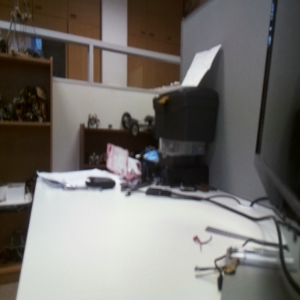

In [40]:
cam_shape = (1640, 922)
nn_shape = (300, 300)
with picamera.PiCamera(resolution=cam_shape, framerate=90, sensor_mode=5) as camera:
    time.sleep(1)
    frame = picamera.array.PiRGBArray(camera, size=nn_shape)
    cont_capture = camera.capture_continuous(frame, 'rgb',
                                             resize=nn_shape,
                                             use_video_port=True)# use GPU for resizing
    for i in range(5):        
        frame.seek(0)
        frame.truncate(0)
        t = time.time()
        next(cont_capture)
        print(time.time() - t)
        im = frame.array

print(im.shape)
PIL.Image.fromarray(im)

In [23]:
import gimbal_control as gc
gc.send_angle_command(0, 0, 60);

/usr/lib/python3/dist-packages/picamera/encoders.py:544: PiCameraResolutionRounded: frame size rounded up from 120x90 to 128x96
  width, height, fwidth, fheight)))


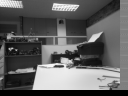

In [11]:
import time
import picamera
import numpy as np
import PIL.Image

with picamera.PiCamera(
         sensor_mode=4,
         resolution='120x90',
         framerate=40) as camera:
    time.sleep(2) # let the camera warm up and set gain/white balance
    y_data = np.empty((96, 128), dtype=np.uint8)
    try:
        t = time.time()
        camera.capture(y_data, 'yuv')
        print(time.time() - t)
    except IOError:
        pass
    im = y_data
PIL.Image.fromarray(im)